In [36]:
import pandas as pd
import json

json_data = json.load(open('../delphi_memory.json', 'r'))
json_data.keys()

responses = json_data['responses']
expert_stats = json_data['expert_stats']


df_responses = pd.DataFrame()
for question in responses:
    df_question = pd.DataFrame(responses[question])
    df_question['question'] = question

    df_question['timestamp'] = pd.to_datetime(df_question['timestamp'])
    df_question = df_question[['question', 'score', 'confidence', 'rationale', 'round_number', 'timestamp']]
    df_responses = pd.concat([df_responses, df_question], ignore_index=True)
df_responses

df_experts = pd.DataFrame()
for question in expert_stats:
    
    df_question = pd.DataFrame(expert_stats[question])
    df_question['question'] = question
    
    df_question = df_question[['question', 'median', 'q1', 'q3', 'mean', 'std']]
    
    df_experts = pd.concat([df_experts, df_question], ignore_index=True)
    

df_experts = df_experts.drop_duplicates()
# df_experts
# df_responses

In [37]:
import matplotlib.pyplot as plt

def plot_score_evolution(question, df_responses, df_experts):
    df_1 = df_responses[df_responses['question'] == question]
    df_2 = df_experts[df_experts['question'] == question]

    # Criar scatter plots separados para cada round para ter legenda adequada
    rounds = df_1['round_number'].unique()
    colors = ['green', 'blue', 'orange', 'purple', 'brown', 'pink']

    for i, round_num in enumerate(sorted(rounds)):
        round_data = df_1[df_1['round_number'] == round_num].sort_values(by='timestamp', ascending=False).head(1)
        plt.scatter(
            round_data['confidence'], 
            round_data['score'], 
            label=f'Round {round_num}', 
            color=colors[i],
            alpha=0.7)
        
        # add notation for round number near the point
        for _, row in round_data.iterrows():
            plt.text(row['confidence']*1.001, row['score']*1.001, f'R{round_num}', fontsize=9, color=colors[i])

    plt.axhline(y=df_2['median'].values[0], color='r', linestyle='--', label='Median Expert Score')
    # plt.fill_betweenx([0, 100], df_2['q1'].values[0], df_2['q3'].values[0], color='r', alpha=0.2, label='Expert Q1-Q3 Range')
    plt.ylabel('Score')
    plt.xlabel('Confidence')
    plt.xlim([0,5])
    plt.ylim([0,9])
    plt.title(f'Score vs Confidence for \n{question}')
    plt.legend()
    plt.show()


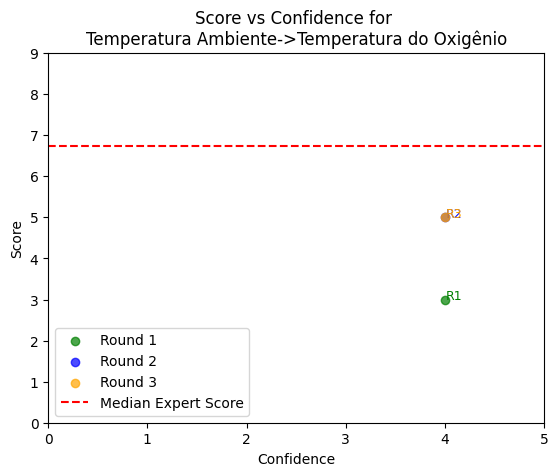

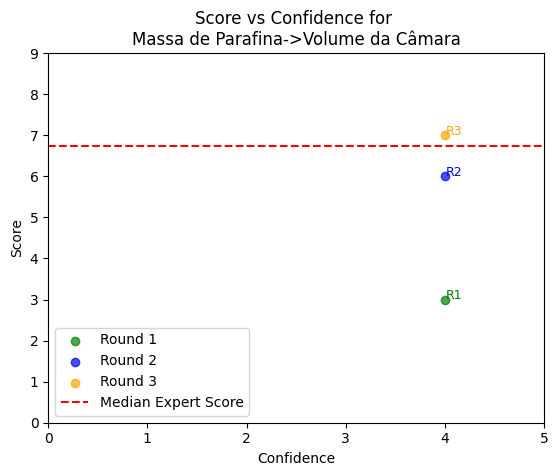

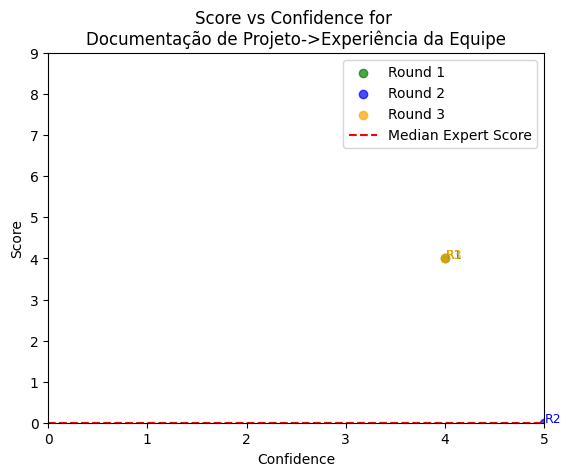

In [38]:
perguntas_com_maior_divergencia = df_responses.groupby('question').agg(
    media_respostas = ('score', 'mean'),
    desvio_padrao_respostas = ('score', 'std'),
    ).reset_index().sort_values(by='desvio_padrao_respostas', ascending=False)


for question in perguntas_com_maior_divergencia['question'].head(3):
    plot_score_evolution(question, df_responses, df_experts)

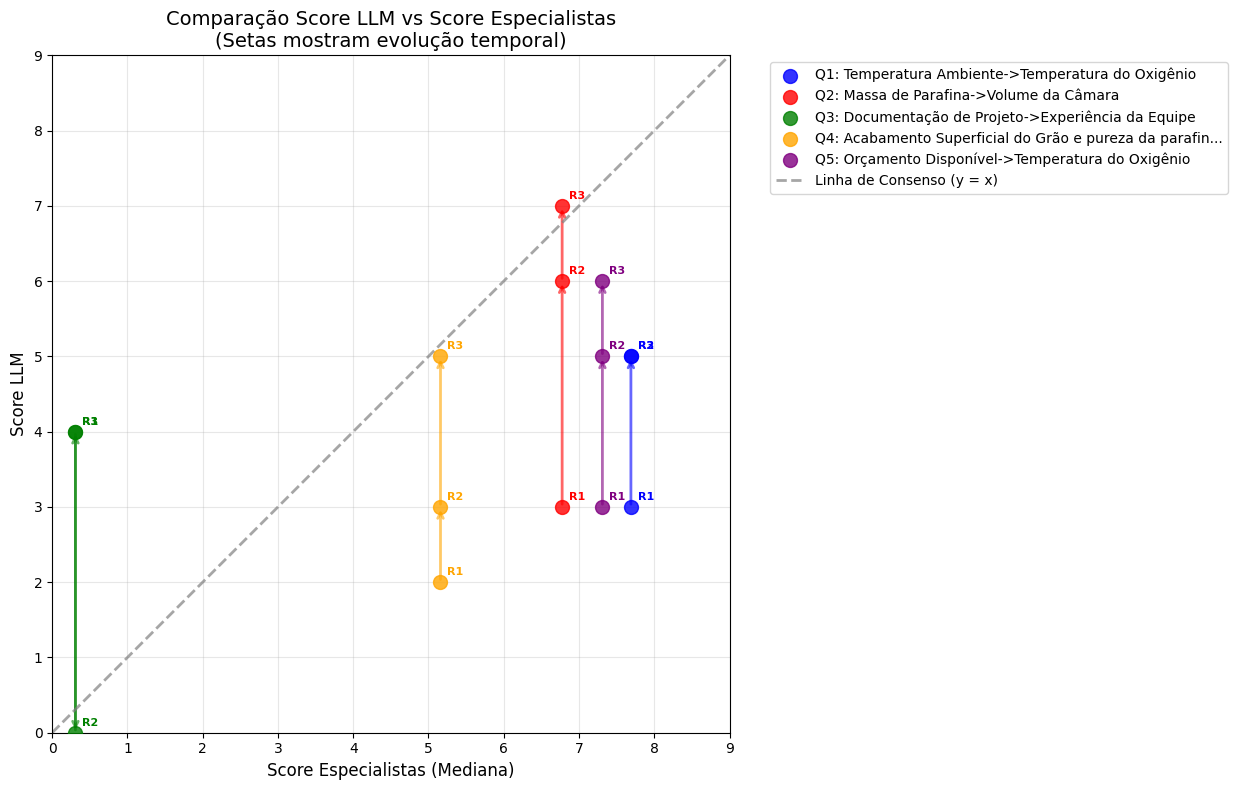

In [48]:
def plot_llm_vs_experts_comparison(questions, df_responses, df_experts):
    """
    Plota Score LLM vs Score Especialistas para múltiplas perguntas em um único gráfico
    Eixo X: Score Especialistas (mediana)
    Eixo Y: Score LLM (resposta do modelo)
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Cores diferentes para cada pergunta
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    for i, question in enumerate(questions):
        df_question = df_responses[df_responses['question'] == question]
        df_expert = df_experts[df_experts['question'] == question]
        
        if df_expert.empty:
            continue
            
        expert_median = df_expert['median'].iloc[0] + np.random.rand()
        
        # Obter dados por rodada (mais recente de cada rodada)
        rounds_data = []
        for round_num in sorted(df_question['round_number'].unique()):
            round_data = df_question[df_question['round_number'] == round_num].sort_values(by='timestamp', ascending=False).head(1)
            if not round_data.empty:
                rounds_data.append({
                    'round': round_num,
                    'expert_score': expert_median,
                    'llm_score': round_data['score'].iloc[0]
                })
        
        if len(rounds_data) > 0:
            # Plotar pontos
            expert_scores = [data['expert_score'] for data in rounds_data]
            llm_scores = [data['llm_score'] for data in rounds_data]
            rounds = [data['round'] for data in rounds_data]
            
            # Scatter plot para os pontos
            ax.scatter(expert_scores, llm_scores, 
                      color=colors[i], 
                      s=100, 
                      alpha=0.8, 
                      label=f'Q{i+1}: {question[:50]}...' if len(question) > 50 else f'Q{i+1}: {question}',
                      zorder=3)
            
            # Conectar pontos com setas (evolução temporal)
            if len(rounds_data) > 1:
                for j in range(len(rounds_data) - 1):
                    x1, y1 = expert_scores[j], llm_scores[j]
                    x2, y2 = expert_scores[j+1], llm_scores[j+1]
                    
                    # Desenhar seta
                    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                               arrowprops=dict(arrowstyle='->', 
                                             color=colors[i], 
                                             alpha=0.6,
                                             lw=2),
                               zorder=2)
            
            # Adicionar anotações com número da rodada
            for j, (expert_score, llm_score, round_num) in enumerate(zip(expert_scores, llm_scores, rounds)):
                ax.annotate(f'R{round_num}', 
                           (expert_score, llm_score), 
                           xytext=(5, 5), 
                           textcoords='offset points',
                           fontsize=8,
                           color=colors[i],
                           fontweight='bold')
    
    # Linha de consenso (y = x)
    min_val = 0
    max_val = 9
    ax.plot([min_val, max_val], [min_val, max_val], 
            color='gray', 
            linestyle='--', 
            alpha=0.7,
            linewidth=2,
            label='Linha de Consenso (y = x)')
    
    # Configurações do gráfico
    ax.set_xlabel('Score Especialistas (Mediana)', fontsize=12)
    ax.set_ylabel('Score LLM', fontsize=12)
    ax.set_xlim([0, 9])
    ax.set_ylim([0, 9])
    ax.set_title('Comparação Score LLM vs Score Especialistas\n(Setas mostram evolução temporal)', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Garantir que os eixos tenham a mesma escala
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.show()

# Plotar gráfico de comparação LLM vs Especialistas

top_questions = perguntas_com_maior_divergencia['question'].head(5).tolist()
plot_llm_vs_experts_comparison(top_questions, df_responses, df_experts)